In [13]:
import os
import numpy as np
import nibabel as nib
import h5py
import time
import brainsss
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
%matplotlib inline

In [145]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
func_path = os.path.join(dataset_path, 'fly_134', 'func_0')

In [190]:
z=30

# Load neural activity and make clusters

In [191]:
brain_path = os.path.join(func_path, 'functional_channel_2_moco_zscore_highpass.h5')
with h5py.File(brain_path, 'r+') as h5_file:
    brain = h5_file.get("data")[:,:,z,:].astype('float32')
brain.shape

(256, 128, 3384)

In [192]:
neural_activity = brain.reshape(-1, 3384)
neural_activity.shape

(32768, 3384)

In [193]:
cluster_dir = os.path.join(func_path, 'clustering')
if not os.path.exists(cluster_dir):
    os.mkdir(cluster_dir)

In [194]:
n_clusters = 2000
t0 = time.time()

connectivity = grid_to_graph(256,128)
cluster_model = AgglomerativeClustering(n_clusters=n_clusters,
                                memory=cluster_dir,
                                linkage='ward',
                                connectivity=connectivity)
cluster_model.fit(neural_activity)
print('Duration: {}'.format(time.time()-t0))

Duration: 8.77415943145752


/home/groups/trc/python/lib/python3.6/site-packages/sklearn/cluster/_agglomerative.py:859: UserWarning: Persisting input arguments took 0.78s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **kwargs)


In [195]:
signals = []
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model.labels_==cluster_num)[0]
    mean_signal = np.mean(neural_activity[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
cluster_signals=np.asarray(signals)

In [196]:
cluster_signals.shape

(2000, 3384)

# load visual stim

In [197]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

### Get Metadata ###
stim_ids, angles = brainsss.get_stimulus_metadata(vision_path)
print(F"Found {len(stim_ids)} presented stimuli.")

# *100 puts in units of 10ms, which will match fictrac
starts_angle_0 = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == 0]
starts_angle_180 = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == 180]
print(F"starts_angle_0: {len(starts_angle_0)}. starts_angle_180: {len(starts_angle_180)}")

loading photodiode data... done
Loaded from Pickle.
Found 753 presented stimuli.
starts_angle_0: 374. starts_angle_180: 374


# load fictrac

In [198]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

Trying to load timestamp data from hdf5 file.
Success.


In [199]:
####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZpos', 'dRotLabZneg']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZpos': short = 'Zpos'
    elif behavior == 'dRotLabZneg': short = 'Zneg'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps,
                                                        resolution, expt_len,
                                                        behavior, timestamps=timestamps,z=z)

In [200]:
### make variance similar by dividing by std

for behavior in ['Y', 'Zpos', 'Zneg']:
    fictrac[behavior] /= np.std(fictrac[behavior])

# make visual vectors

In [201]:
# stimulus_start_times will be beginning of hold.
# so lets add 500ms to start time
# and set stop time to be 500ms past that

In [202]:
### ANGLE 0 ###
# not actually grey

grey_starts = []
grey_stops = []
for i,stim in enumerate(stim_ids):
    if stim == 'DriftingSquareGrating':
        if angles[i] == 0:
            start_time = stimulus_start_times[i]+.5 # add 500ms for hold
            grey_starts.append(start_time)
            grey_stops.append(start_time+.6) #look at 600ms window
grey_starts = [i*1000 for i in grey_starts] # convert from s to ms
grey_stops = [i*1000 for i in grey_stops] # convert from s to ms
idx_to_use = []
for i in range(len(grey_starts)):
    idx_to_use.extend(np.where((grey_starts[i] < timestamps[:,0]) & (timestamps[:,0] < grey_stops[i]))[0])
idx_to_use_angle_0 = idx_to_use    

### this is now a list of indices where grey stim was presented

In [203]:
### ANGLE 180 ###
# not actually grey

grey_starts = []
grey_stops = []
for i,stim in enumerate(stim_ids):
    if stim == 'DriftingSquareGrating':
        if angles[i] == 180:
            start_time = stimulus_start_times[i]+.5 # add 500ms for hold
            grey_starts.append(start_time)
            grey_stops.append(start_time+.6) #look at 600ms window
grey_starts = [i*1000 for i in grey_starts] # convert from s to ms
grey_stops = [i*1000 for i in grey_stops] # convert from s to ms
idx_to_use = []
for i in range(len(grey_starts)):
    idx_to_use.extend(np.where((grey_starts[i] < timestamps[:,0]) & (timestamps[:,0] < grey_stops[i]))[0])
idx_to_use_angle_180 = idx_to_use    

### this is now a list of indices where grey stim was presented

(100, 500)

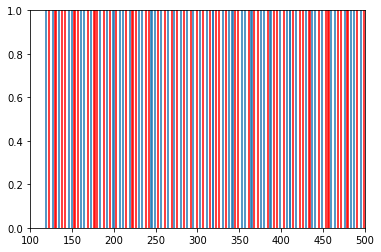

In [204]:
for i in idx_to_use_angle_0:
    plt.axvline(i)
    
for i in idx_to_use_angle_180:
    plt.axvline(i,color='r')
    
plt.xlim(100,500)

In [205]:
visual = {}
visual['0'] = np.zeros((3384))
visual['0'][idx_to_use_angle_0] = 1

visual['180'] = np.zeros((3384))
visual['180'][idx_to_use_angle_180] = 1

# Fit model

In [206]:
from sklearn.linear_model import LinearRegression

In [207]:
cluster_signals.shape

(2000, 3384)

In [208]:
def fit_linear_model(Y, Xs, scores):
    X = np.asarray(Xs).T #stack Xs
    model = LinearRegression().fit(X,Y)
    scores.append(np.sqrt(model.score(X,Y)))
    return scores

In [209]:
### make interaction variables
# angle==0 is rightward movement
# this should cause Zneg

zpos_0 = visual['0']*fictrac['Zpos']
zpos_180 = visual['180']*fictrac['Zpos']
zneg_0 = visual['0']*fictrac['Zneg']
zneg_180 = visual['180']*fictrac['Zneg']

In [210]:
def LOO(LO):
    all_x = [fictrac['Y'], fictrac['Zpos'], fictrac['Zneg'],
         visual['0'], visual['180'],
         zpos_0, zpos_180, zneg_0, zneg_180]
    all_x.pop(LO)
    return all_x

In [233]:
scores = {'all': [],
          'Y': [], 'Zpos': [], 'Zneg': [], 'visual0': [], 'visual180': [],
          'zpos_0': [], 'zpos_180': [], 'zneg_0': [], 'zneg_180': [],
          'LO_Y': [], 'LO_Zpos': [], 'LO_Zneg':[], 'LO_visual0':[],'LO_visual180':[],
          'LO_zpos_0': [], 'LO_zpos_180': [], 'LO_zneg_0': [], 'LO_zneg_180': []}

for cluster_num in range(n_clusters):
    if cluster_num%500 == 0:
        print(cluster_num)

    Y = cluster_signals[cluster_num,:]
    
    ### all
    all_x = [fictrac['Y'], fictrac['Zpos'], fictrac['Zneg'],
             visual['0'], visual['180'],
             zpos_0, zpos_180, zneg_0, zneg_180]
    scores['all'] = fit_linear_model(Y, all_x, scores['all'])
    
    ### singles
    scores['Y'] = fit_linear_model(Y, [fictrac['Y']], scores['Y'])
    scores['Zpos'] = fit_linear_model(Y, [fictrac['Zpos']], scores['Zpos'])
    scores['Zneg'] = fit_linear_model(Y, [fictrac['Zneg']], scores['Zneg'])
    scores['visual0'] = fit_linear_model(Y, [visual['0']], scores['visual0'])
    scores['visual180'] = fit_linear_model(Y, [visual['180']], scores['visual180'])

    ### single interactions
#     scores['zpos_0'] = fit_linear_model(Y, [zpos_0], scores['zpos_0'])
#     scores['zpos_180'] = fit_linear_model(Y, [zpos_180], scores['zpos_180'])
#     scores['zneg_0'] = fit_linear_model(Y, [zpos_0], scores['zneg_0'])
#     scores['zneg_180'] = fit_linear_model(Y, [zpos_0], scores['zneg_180'])
    
    ### LO (leave out)
    
    scores['LO_Y'] = fit_linear_model(Y, LOO(0), scores['LO_Y'])
    scores['LO_Zpos'] = fit_linear_model(Y, LOO(1), scores['LO_Zpos'])
    scores['LO_Zneg'] = fit_linear_model(Y, LOO(2), scores['LO_Zneg'])
    scores['LO_visual0'] = fit_linear_model(Y, LOO(3), scores['LO_visual0'])
    scores['LO_visual180'] = fit_linear_model(Y, LOO(4), scores['LO_visual180'])
    scores['LO_zpos_0'] = fit_linear_model(Y, LOO(5), scores['LO_zpos_0'])
    scores['LO_zpos_180'] = fit_linear_model(Y, LOO(6), scores['LO_zpos_180'])
    scores['LO_zneg_0'] = fit_linear_model(Y, LOO(7), scores['LO_zneg_0'])
    scores['LO_zneg_180'] = fit_linear_model(Y, LOO(8), scores['LO_zneg_180'])

0


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


500


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


1000
1500


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


In [250]:
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model.labels_==cluster_num)[0]
    #colored_by_betas[cluster_indicies] = scores['visual180'][cluster_num]
    colored_by_betas[cluster_indicies] = scores['all'][cluster_num] - scores['LO_zneg_180'][cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

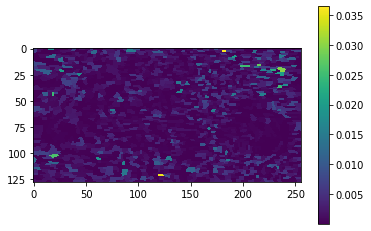

In [251]:
plt.imshow(colored_by_betas.T)
plt.colorbar()

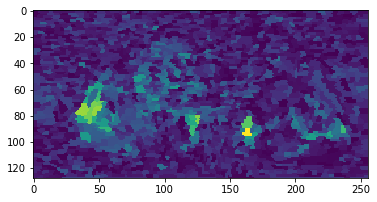

In [106]:
plt.imshow(colored_by_betas.T) #zneg_0

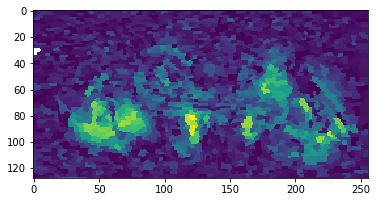

In [108]:
plt.imshow(colored_by_betas.T) #zpos_180

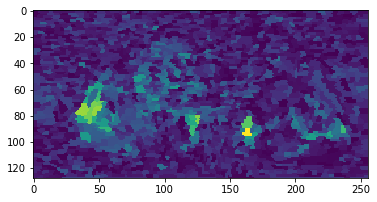

In [110]:
plt.imshow(colored_by_betas.T) #zneg_180

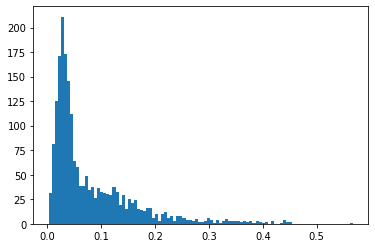

In [49]:
plt.hist(scores,bins=100);